<a href="https://colab.research.google.com/github/bzizmza/Text-Classification/blob/main/Text_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text Classification Project
## by Abimanyu Sri Setyo

**Project Criteria**
* The dataset to be used is free, but has a minimum of 1000 samples.
* Must use LSTM in model architecture.
* Must use sequential model.
* Validation set is 20% of the total dataset.
* Must use Embedding.
* Must use tokenizer function.
* The accuracy of the model is at least 75% on the train set and validation set.

## Import Dataset
Using data from [Kaggle](https://www.kaggle.com/atulanandjha/imdb-50k-movie-reviews-test-your-bert) and put it into my Google Drive to make it easier to process.

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/Dataset/Movie Reviews/train.csv')

In [3]:
df.head()

,text,sentiment
0,"Now, I won't deny that when I purchased this o...",neg
1,"The saddest thing about this ""tribute"" is that...",neg
2,Last night I decided to watch the prequel or s...,neg
3,I have to admit that i liked the first half of...,neg
4,I was not impressed about this film especially...,neg


## Encoding
Change the shape of the data in the sentiment column into a number form for labeling each data.

In [4]:
cat = pd.get_dummies(df.sentiment)
df = pd.concat([df, cat], axis=1)
df = df.drop(columns='sentiment')

In [5]:
df.head()

,text,neg,pos
0,"Now, I won't deny that when I purchased this o...",1,0
1,"The saddest thing about this ""tribute"" is that...",1,0
2,Last night I decided to watch the prequel or s...,1,0
3,I have to admit that i liked the first half of...,1,0
4,I was not impressed about this film especially...,1,0


## Split Dataframe
For the model to process, I need to convert the values from the dataframe into the numpy array data type using the values attribute.

In [6]:
review = df['text'].values
label = df[['neg', 'pos']].values

In [7]:
review

array(["Now, I won't deny that when I purchased this off eBay, I had high expectations. This was an incredible out-of-print work from the master of comedy that I so enjoy. However, I was soon to be disappointed. Apologies to those who enjoyed it, but I just found the Compleat Al to be very difficult to watch. I got a few smiles, sure, but the majority of the funny came from the music videos (which I've got on DVD) and the rest was basically filler. You could tell that this was not Al's greatest video achievement (that honor goes to UHF). Honestly, I doubt if this will ever make the jump to DVD, so if you're an ultra-hardcore Al fan and just HAVE to own everything, buy the tape off eBay. Just don't pay too much for it.",
       'The saddest thing about this "tribute" is that almost all the singers (including the otherwise incredibly talented Nick Cave) seem to have missed the whole point where Cohen\'s intensity lies: by delivering his lines in an almost tuneless poise, Cohen transmits 

In [8]:
label

array([[1, 0],
       [1, 0],
       [1, 0],
       ...,
       [1, 0],
       [1, 0],
       [1, 0]], dtype=uint8)

In [9]:
from sklearn.model_selection import train_test_split

text = df['text'].values
y = df[['pos','neg']].values
text_train , text_test, y_train, y_test = train_test_split(text, y, test_size=0.2)

## Tokenizer
Then, I convert every word in our dataset into a numeric number with the Tokenizer function. Once tokenization is complete, I need to make convert each sample into a sequence.

In [10]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [11]:
tokenizer = Tokenizer(num_words=280617, oov_token='-')
tokenizer.fit_on_texts(text_train)
tokenizer.fit_on_texts(text_test)

In [12]:
seq_train = tokenizer.texts_to_sequences(text_train)
seq_test = tokenizer.texts_to_sequences(text_test)

In [13]:
pad_train = pad_sequences(seq_train,
                          maxlen=300,
                          padding='post',
                          truncating='post')

pad_test = pad_sequences(seq_test,
                         maxlen=300,
                         padding='post',
                         truncating='post')

## Embedding
For the model architecture, I use the Embedding layer with the embedding dimension of 16, and the input dimension of the num_words value in the tokenizer object.

In [14]:
from tensorflow.keras import layers
from tensorflow.keras import Sequential

model = Sequential([layers.Embedding(280617, 64, input_length=300),
                    layers.LSTM(64, dropout=0.1),
                    layers.Dense(128, activation='relu'),
                    layers.Dense(64, activation='relu'),
                    layers.Dense(2, activation='sigmoid')])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 64)           17959488  
                                                                 
 lstm (LSTM)                 (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 2)                 130       
                                                                 
Total params: 18,009,218
Trainable params: 18,009,218
Non-trainable params: 0
_________________________________________________________________


## Callback
Then, I created a callback function, its function is to prevent overfitting and stop training after it's done accumulating.

In [15]:
import tensorflow
class myCallback(tensorflow.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') > 0.9):
      print("\nAccuracy above 90%, Training Stop!")
      self.model.stop_training = True

callbacks = myCallback()

## Training Model
Finally, I can start training our model by calling the fit() function.

In [16]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])


In [17]:
history = model.fit(pad_train, y_train,
                    batch_size=128,
                    epochs=30,
                    validation_data=(pad_test, y_test),
                    verbose=2,
                    callbacks=[callbacks])

Epoch 1/30
157/157 - 8s - loss: 0.6925 - accuracy: 0.5075 - val_loss: 0.6790 - val_accuracy: 0.5486 - 8s/epoch - 53ms/step
Epoch 2/30
157/157 - 4s - loss: 0.6610 - accuracy: 0.5594 - val_loss: 0.6425 - val_accuracy: 0.5918 - 4s/epoch - 28ms/step
Epoch 3/30
157/157 - 4s - loss: 0.6083 - accuracy: 0.6651 - val_loss: 0.6069 - val_accuracy: 0.6686 - 4s/epoch - 28ms/step
Epoch 4/30
157/157 - 4s - loss: 0.6124 - accuracy: 0.6400 - val_loss: 0.6938 - val_accuracy: 0.5550 - 4s/epoch - 28ms/step
Epoch 5/30
157/157 - 4s - loss: 0.6179 - accuracy: 0.6123 - val_loss: 0.6403 - val_accuracy: 0.7364 - 4s/epoch - 28ms/step
Epoch 6/30
157/157 - 4s - loss: 0.6076 - accuracy: 0.6219 - val_loss: 0.7249 - val_accuracy: 0.5296 - 4s/epoch - 28ms/step
Epoch 7/30
157/157 - 4s - loss: 0.5750 - accuracy: 0.6059 - val_loss: 0.7682 - val_accuracy: 0.5456 - 4s/epoch - 28ms/step
Epoch 8/30
157/157 - 4s - loss: 0.5451 - accuracy: 0.6252 - val_loss: 0.7705 - val_accuracy: 0.5382 - 4s/epoch - 28ms/step
Epoch 9/30
157/1

## Evaluation Model
I use the matplotlib library to create a plot model to make it easier to evaluate the model that has been created.

In [18]:
import matplotlib.pyplot as plt


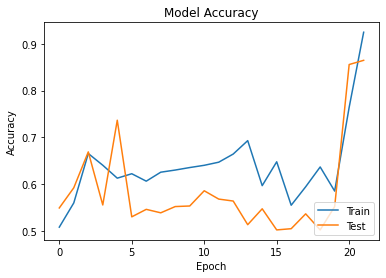

In [19]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend(['Train', 'Test'], loc='lower right')
plt.show()